# **Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Deafult Settings**

Some general settings used on the notebook

In [2]:
# Set aspects of the visual theme for all matplotlib and seaborn plots.
sns.set()

# **Loading and Processing Datasets**

In [3]:
goalscorers = pd.read_csv('goalscorers.csv')
shootouts = pd.read_csv('shootouts.csv')
results = pd.read_csv('results.csv')

## **Goalscorers**

In [4]:
# Change type of date column to datetime
goalscorers['date'] = pd.to_datetime(goalscorers.date)
# Add column year
goalscorers['year'] = goalscorers.date.map(lambda x: x.year)
goalscorers.head(5)

,date,home_team,away_team,team,scorer,minute,own_goal,penalty,year
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False,1916
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False,1916
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False,1916
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False,1916
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False,1916


## **Shootouts**

In [5]:
shootouts.head(5)

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-07,South Korea,Iraq,Iraq
3,1972-05-17,Thailand,South Korea,South Korea
4,1972-05-19,Thailand,Cambodia,Thailand


## **Results**

In [30]:
# Create a goal_dif column
results['goal_dif'] = results['home_score'] - results['away_score']
# Create a total_goals column
results['total_goals'] = results['home_score'] + results['away_score']
# Change type of date column to datetime
results['date'] = pd.to_datetime(results.date)
# Add column year
results['year'] = results.date.map(lambda x: x.year)
results.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,goal_dif,total_goals,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0,0,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,2,6,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1,3,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,0,4,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,3,3,1876
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False,4,4,1876
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,-2,4,1877
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False,-2,2,1877
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,5,9,1878
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False,9,9,1878


## **Bonus - Elo Ranking**

The World Football Elo Ratings are based on the Elo rating system. This system is used by FIDE, the international chess federation, to rate chess players.

We can apply the Elo rating system to international football, by adding a weighting for the kind of match, an adjustment for the home team advantage, and an adjustment for goal difference in the match result.

All teams must start with 1500 points.

The ratings are based on the following formulas:

Rn = Ro + G x K × (W - We)

- Rn is the new rating, Ro is the old (pre-match) rating.
- G is a goal difference index
    - If 0 or 1: 1
    - If 2: 3/2
    - If 3 or more: (11 + goal_dif) / 8
- K is the weight constant for the tournament played (We made an adjustmant from the reference):
    - 60 for World Cup Matches;
    - 50 for continental championships and major intercontinental tournaments;
    - 40 for World Cup qualifiers and major tournaments;
    - 30 for Continental qualifiers and major tournaments;
    - 20 for Friendly and other tournaments
- W is the result of the game (1 for a win, 0.5 for a draw, and 0 for a loss).
- We is the expected result (win expectancy), either from the chart or the following formula:
    - We = 1 / (10**(-dr/400) + 1)
    - dr equals the difference in ratings plus 100 points for a team playing at home.
    
Reference: https://www.eloratings.net/about

### **Functions implementation**

In [7]:
# Return expected result probabilty
def expected_result(ranking_a, ranking_b, home_advantage):
    return 1 / (10**(-((ranking_a+home_advantage)-ranking_b)/400) + 1)

# Return result by goal diference
def result(goal_dif):
    # return 0 to lost
    if goal_dif < 0:
        return 0
    # return 0.5 to draw
    elif goal_dif == 0:
        return 0.5
    # return 1 to win
    return 1


# The number of goals is taken into account by use of a goal difference index
def goal_index(goal_dif):
    goal_dif = abs(goal_dif)
    if goal_dif <= 1:
        return 1
    elif goal_dif == 2:
        return 3/2
    else:
        return (11 + goal_dif) / 8


# Return tournament weight constant
def tournament_weight(tournament):
    # 60 points
    world_cup = 'FIFA World Cup'
    # 50 points
    continental = ['AFC Asian Cup', 'Africa Cup of Nations',
                  'CONCACAF Gold Cup', 'Copa América', 'OFC Nations Cup',
                  'UEFA European Championship', 'CONCACAF Cup', 'AFC Solidarity Cup',
                  'AFC Challenge Cup', 'Confederations Cup', 'CONMEBOL–UEFA Cup of Champions']
    # 40 points
    international_qualifiers_and_majors = ['UEFA Nations League', 'FIFA World Cup qualification',  
                                           'CONCACAF Nations League', 'African Nations Championship']
    # 30 points
    continental_qualifiers = ['UEFA Euro qualification', 'African Cup of Nations qualification', 'AFC Asian Cup qualification',
                              'Copa América qualification']
    # 20 points + others
    friendly = 'Friendly'
    
    if tournament == world_cup:
        return 60
    elif tournament in continental:
        return 50
    elif tournament in international_qualifiers_and_majors:
        return 40
    elif tournament in continental_qualifiers:
        return 30
    elif tournament == friendly:
        return 20
    else:
        return 20


# Calculate change of points
def points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=100):
    g = goal_index(goal_dif)
    k = tournament_weight(tournament)
    w = result(goal_dif)
    we = expected_result(ranking_a, ranking_b, home_advantage)
    return g * k * (w - we)


# Return the new ranking of the team
def elo(ranking_a, ranking_b, goal_dif, tournament, neutral, home=True):
    if neutral and home:
        return ranking_a + points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=0)
    elif neutral and not home:
        return ranking_b - points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=0)
    elif home:
        return ranking_a + points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=100)
    return ranking_b - points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=100)

### **Data Processing**

In [8]:
# Assigning default rating of 1500 to each team
unique_team_list = np.unique(pd.concat([results.home_team, results.away_team], ignore_index=True))
rating_dict = {team:1500 for team in unique_team_list}
# Assign each year of dataset
year_list = results.year.unique()
year_dict = dict()

# Itarate years to calculate elo ranking
for year in year_list:
    # Select mask with year of the iteration
    mask = results['year'] == year
    results_temp = results[mask][['home_team', 'away_team', 'goal_dif', 'tournament', 'neutral']]
    
    # Iterate dataframe to calculate elo ranking changes
    for index, row in results_temp.iterrows():
        
        # Get home and away teams names
        home_team = row.home_team
        away_team = row.away_team
        
        # Get other informations
        goal_dif = row.goal_dif
        tournament = row.tournament
        neutral = row.neutral
        
        # Get home and away teams scores
        home_team_score = rating_dict[home_team]
        away_team_score = rating_dict[away_team]
        
        # Calculate new scores according to result of the match
        home_team_score = elo(home_team_score, away_team_score, goal_dif, tournament, neutral, home=True)
        away_team_score = elo(home_team_score, away_team_score, goal_dif, tournament, neutral, home=False)
        
        # Assign new scores
        rating_dict[home_team] = home_team_score
        rating_dict[away_team] = away_team_score

    # Transform rating_dict into DataFrame
    year_dict[year] = rating_dict.copy()

country_ranking = pd.DataFrame.from_dict(year_dict)
country_ranking = country_ranking.reset_index().rename(columns={'index': 'country'})
country_ranking.head()

,country,1872,1873,1874,1875,1876,1877,1878,1879,1880,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Abkhazia,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1495.795646,1495.795646,1541.851957,1537.114724,1573.851851,1590.416934,1590.416934,1590.416934,1590.416934,1590.416934
1,Afghanistan,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1297.171850,1322.079335,1326.033712,1334.662828,1327.902339,1323.648908,1323.648908,1327.496183,1292.290165,1292.290165
2,Albania,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1611.563089,1632.313054,1599.557607,1623.529074,1539.358011,1554.754631,1578.002721,1608.412824,1571.702703,1568.422788
3,Alderney,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1401.560612,1359.478499,1359.478499,1347.580703,1347.580703,1340.406325,1340.406325,1340.406325,1340.406325,1340.406325
4,Algeria,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1747.113271,1748.196510,1722.458934,1667.296094,1628.919370,1753.821646,1768.790654,1829.319128,1806.916842,1810.859116


### Adding features

In [9]:
# Add country confederation
country_confederation = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/fifa/fifa_countries_audience.csv')
country_confederation_country = np.array(country_confederation.country)
country_confederation_confed = np.array(country_confederation.confederation)
country_confederation_dict = dict(zip(country_confederation_country, country_confederation_confed))
country_confederation_dict['England'] = 'UEFA'
country_confederation_dict['Scotland'] = 'UEFA'
country_ranking['confederation'] = country_ranking['country'].apply(lambda x : country_confederation_dict.get(x))
country_ranking.confederation.fillna('Not Found', inplace=True)

# Add country shortcode
country_shortcode = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
country_code_name = np.array(country_shortcode.name)
country_code_alpha = np.array(country_shortcode['alpha-2'])
country_code_dict = dict(zip(country_code_name, country_code_alpha))
country_ranking['code'] = country_ranking['country'].apply(lambda x : country_code_dict.get(x))
country_ranking.code = ':' + country_ranking.code.str.lower() + ':'
country_ranking[['country', 2023, 'confederation', 'code']].head()

,country,2023,confederation,code
0,Abkhazia,1590.416934,Not Found,NaN
1,Afghanistan,1292.290165,AFC,:af:
2,Albania,1568.422788,UEFA,:al:
3,Alderney,1340.406325,Not Found,NaN
4,Algeria,1810.859116,CAF,:dz:


# **Gráfico de Dispersão**

# **Histogram**

## **Goalscorers**

## **Shootouts**

## **Results** 


# **Gráfico de Linha**

## **Goalscorers**

### **1. Penalty Goal Rate per Year**


Penalty goals ratio is calculated by dividing penalty goals by total goals

In [10]:
penalty_rate = pd.crosstab(goalscorers.year, goalscorers.penalty)
penalty_rate['rate'] = penalty_rate[1] / penalty_rate[0]
penalty_rate

penalty,False,True,rate
year,,,
1916,16,2,0.125000
1917,17,4,0.235294
1919,27,0,0.000000
1920,15,1,0.066667
1921,14,0,0.000000
...,...,...,...
2018,147,22,0.149660
2019,1428,131,0.091737
2020,82,15,0.182927


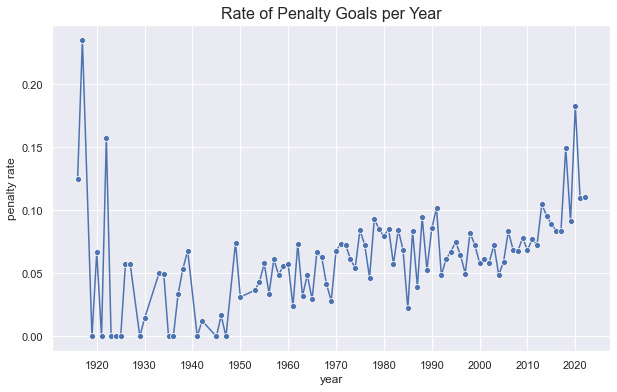

In [11]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=penalty_rate, x='year', y='rate', marker='o')
plt.locator_params(axis='x', nbins=20)
ax.set_title("Rate of Penalty Goals per Year", size=16)
ax.set_ylabel("penalty rate")

# Show
plt.show()

## **Results** 

### **1. Goal Rate per Year**


Goal rate is calculated by dividing the number of goals by the number of games in one year

Matches before 1930 were removed becouse of lower number games

In [12]:
# All goals by year
total_goals = results.groupby(by='year')['total_goals'].sum()
# All matches by year
total_matches = results.year.value_counts()
# Goal rate by year
goal_rate = total_goals / total_matches
goal_rate = goal_rate.to_frame().reset_index()
goal_rate.rename(columns={'index': 'year', 0:'goal_rate'}, inplace=True)
# Remove matches before 1930
mask = goal_rate.year >= 1930
goal_rate = goal_rate[mask]
goal_rate

,year,goal_rate
58,1930,4.323232
59,1931,4.237113
60,1932,3.923077
61,1933,3.967742
62,1934,4.814815
...,...,...
147,2019,2.869078
148,2020,2.471572
149,2021,2.746556
150,2022,2.479781


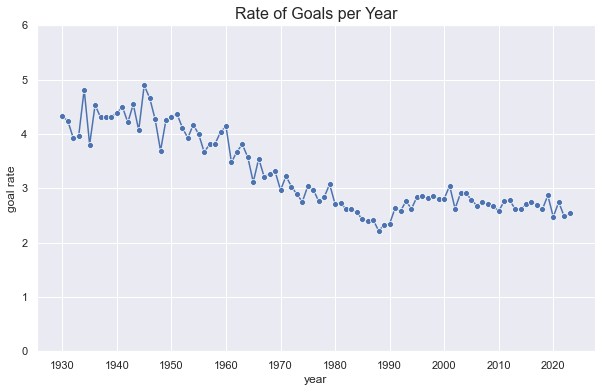

In [13]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=goal_rate, x='year', y='goal_rate', marker='o')
plt.locator_params(axis='x', nbins=20)
ax.set_title("Rate of Goals per Year", size=16)
ax.set_ylabel("goal rate")
ax.set_yticks(list(range(0, 7)))

# Show
plt.show()

# **Gráfico de Barra**

## **Goalscorers**

### **1. Best goalscorers**


Calculated by absolute frequency

In [22]:
# Calculate absolute frequency of wins
goalscorers_count = goalscorers.scorer.value_counts().to_frame().reset_index()
goalscorers_count.rename(columns={'index': 'scorer', 'scorer':'count'}, inplace=True)
goalscorers_count.head()

,scorer,count
0,Cristiano Ronaldo,91
1,Robert Lewandowski,56
2,Lionel Messi,54
3,Ali Daei,49
4,Miroslav Klose,48


**Observation: Data not updated, Lionel Messi and Ali Daei has more than 100 goals**

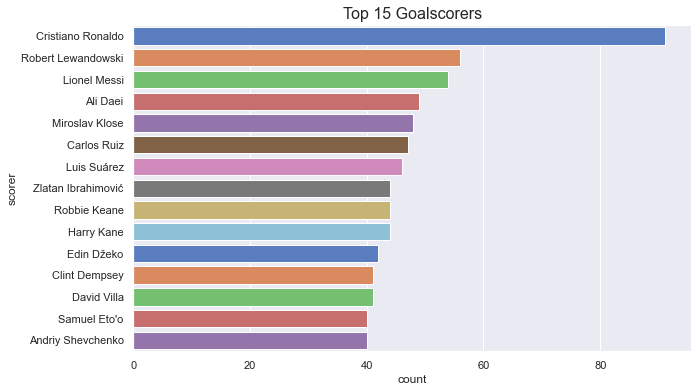

In [26]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=goalscorers_count.head(15), x='count', y='scorer', palette='muted')
ax.set_title("Top 15 Goalscorers", size=16)


# Show
plt.show()

## **Shootouts**

### **1. Teams who played the most penalty shootouts**


Calculated by absolute frequency

In [14]:
# Calculate the absolute frequency
shootouts_rate_domain = shootouts.home_team.value_counts() + shootouts.away_team.value_counts()
# Filter low results
mask = shootouts_rate_domain > 6
shootouts_rate_domain = shootouts_rate_domain[mask]
shootouts_rate_domain = shootouts_rate_domain.to_frame().reset_index()
shootouts_rate_domain.rename(columns={'index': 'country', 0:'total'}, inplace=True)
shootouts_rate_domain.sort_values(by='total', ascending=False, inplace=True)
shootouts_rate_domain.head()

,country,total
54,Zambia,24.0
44,South Korea,23.0
43,South Africa,23.0
2,Argentina,22.0
14,Egypt,22.0


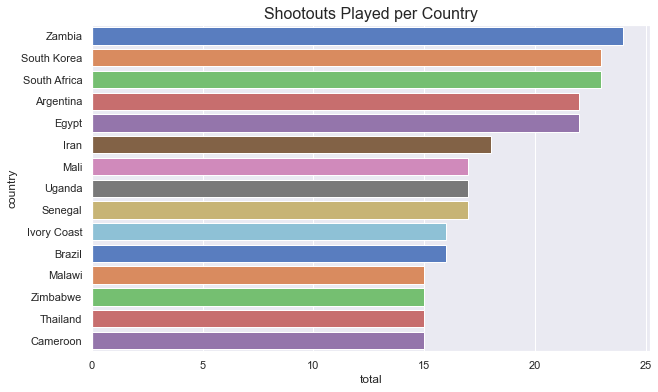

In [15]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_rate_domain.head(15), x='total', y='country', palette='muted')
ax.set_title("Shootouts Played per Country", size=16)


# Show
plt.show()

### **2. Teams who won the most penalty shootouts**


Calculated by absolute frequency

In [16]:
# Calculate absolute frequency of wins
shootouts_count = shootouts.winner.value_counts().to_frame().reset_index()
shootouts_count.rename(columns={'index': 'country'}, inplace=True)
shootouts_count.head()

,country,winner
0,Argentina,14
1,South Korea,13
2,Egypt,13
3,Zambia,13
4,South Africa,11


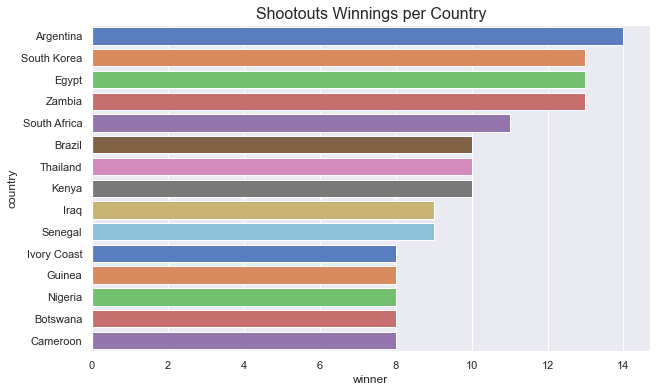

In [17]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_count.head(15), x='winner', y='country', palette='muted')
ax.set_title("Shootouts Winnings per Country", size=16)


# Show
plt.show()

### **3. Teams with best peformance in penalty shootouts**


Division of win frequency by total frequency

In [18]:
shootouts_rate_domain = shootouts.home_team.value_counts() + shootouts.away_team.value_counts()
mask = shootouts_rate_domain > 6
shootouts_rate_domain = shootouts_rate_domain[mask]

shootouts_rate = shootouts.winner.value_counts() / (shootouts_rate_domain)
shootouts_rate = shootouts_rate.dropna()
shootouts_rate = shootouts_rate.to_frame().reset_index().rename(columns={0: "rate", 'index': 'country'})
shootouts_rate.sort_values(by='rate', ascending=False, inplace=True)
shootouts_rate.head()

,country,rate
17,Ethiopia,0.875000
25,Iraq,0.818182
20,Germany,0.750000
22,Guinea,0.727273
29,Kenya,0.714286


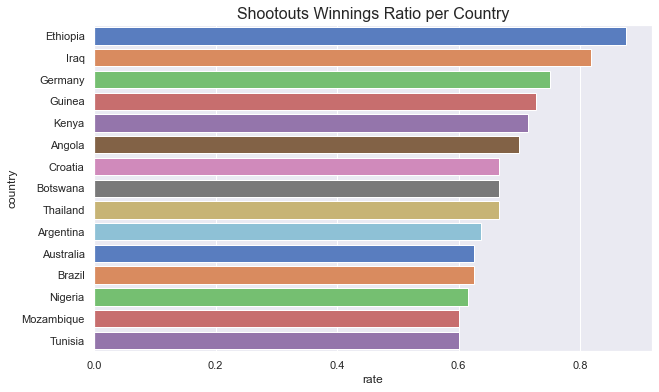

In [19]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_rate.head(15), x='rate', y='country', palette='muted')
ax.set_title("Shootouts Winnings Ratio per Country", size=16)


# Show
plt.show()

## **Bonus - Elo Ranking** 

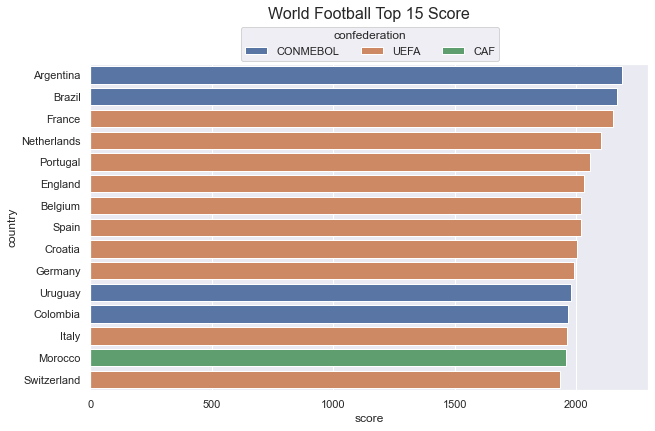

In [27]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=country_ranking.sort_values(by=2023, ascending=False).head(15), x=2023, y='country', hue='confederation', dodge=False)
ax.set_title("World Football Top 15 Score", y=1.12, size=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.26, 1.132), ncol=3)
ax.set_xlabel("score")

# Show
plt.show()

# **Bonus - Flourish Visualization (Elo Ranking)**

The flourish software was used to make a bar chart race of the elo ranking score over the years.

You can acess the visualization running the cell bellow or clicking on the following link: 
- **https://public.flourish.studio/visualisation/13571359/?utm_source=embed&utm_campaign=visualisation/13571359**.

In [29]:
%%HTML
<iframe src='https://flo.uri.sh/visualisation/13571359/embed' title='Interactive or visual content' class='flourish-embed-iframe' frameborder='0' scrolling='no' style='width:100%;height:600px;' sandbox='allow-same-origin allow-forms allow-scripts allow-downloads allow-popups allow-popups-to-escape-sandbox allow-top-navigation-by-user-activation'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/13571359/?utm_source=embed&utm_campaign=visualisation/13571359' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>